Name : Manasi Ringane

Class : B.Tech AIML (A div)

PRN : 22SC114501043

Roll No. : 39

Experiment 1 : Detecting algorithmic bias in hiring dataset

# Experiment No. 1 - Detecting Algorithmic Bias in a Dataset

## 🎯 Objective
The goal of this experiment is to **detect algorithmic bias** in a dataset.  
We will use the **Adult Income Dataset** to predict whether a person earns more than 50K/year.  

Since this dataset contains features like **sex** and **race**, it is often used to demonstrate how machine learning models can show **unfair outcomes**.  
We will train a model and then check if it performs equally across **different demographic groups**.

In [1]:
# 🧩 Step 0 — Install Fairlearn This installs the fairlearn library, which helps in assessing and mitigating unfairness in machine learning models.
!pip install -q fairlearn


In [2]:
!pip install fairlearn 


## 1) Import libraries
We’ll use pandas/scikit-learn for modeling and `fairlearn` for fairness metrics and constraints.


In [11]:
# ===============================
# 1) Import Necessary Libraries
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

from fairlearn.metrics import MetricFrame, selection_rate
from fairlearn.reductions import ExponentiatedGradient, DemographicParity



## 2) Load dataset (robust to header variations)
- Your file path is **`D:\AIES Experiments\Exp 1_aies\adult.csv`** (Windows).
- If running in a different environment, it will try a relative fallback `adult.csv`.
- We also normalize column names to a consistent snake_case format.


In [ ]:
# Load dataset
data = pd.read_csv(r"D:\AIES Experiments\Exp 1_aies\adult.csv")

print("✅ Dataset Loaded")
print("Columns:", data.columns.tolist())
print("\nPreview:\n", data.head())


## 3) Preprocess the Data

Steps:
- Clean column names (remove spaces, replace `.` with `_` for easier handling).
- Encode the target variable `income` (`>50K` → 1, `<=50K` → 0).
- Select a subset of relevant features for simplicity.
- Apply one-hot encoding to categorical variables.


In [12]:
# Clean column names
data.columns = data.columns.str.strip().str.replace(".", "_")

# Encode target column
data["income"] = data["income"].str.strip()
data["income"] = data["income"].replace({"<=50K": 0, ">50K": 1, "<=50K.": 0, ">50K.": 1})

# Select relevant features + target
df = data[["age", "education_num", "hours_per_week", "gender", "race", "income"]].copy()

# One-hot encoding for categorical vars
df_enc = pd.get_dummies(df, drop_first=True)

print("✅ After Encoding")
print(df_enc.head())


✅ After Encoding
   age  education_num  hours_per_week  income  gender_Male  \
0   90              9              40       0        False   
1   82              9              18       0        False   
2   66             10              40       0        False   
3   54              4              40       0        False   
4   41             10              40       0        False   

   race_Asian-Pac-Islander  race_Black  race_Other  race_White  
0                    False       False       False        True  
1                    False       False       False        True  
2                    False        True       False       False  
3                    False       False       False        True  
4                    False       False       False        True  


## 4) Train/Test Split

We split into **features (X)** and **target (y)**.  
We also keep the sensitive attribute `gender_Male` aside for fairness evaluation.


In [13]:
# Features and target
X = df_enc.drop(columns=["income"])
y = df_enc["income"]

# Sensitive attribute: gender (encoded as gender_Male)
sf = df_enc["gender_Male"]

# Split
X_train, X_test, y_train, y_test, sf_train, sf_test = train_test_split(
    X, y, sf, test_size=0.3, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)


Train size: (22792, 8)  Test size: (9769, 8)


## 5) Train a Logistic Regression Model


In [14]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("✅ Model Trained")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


✅ Model Trained
Accuracy: 0.8063261336881974

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.94      0.88      7417
           1       0.66      0.40      0.50      2352

    accuracy                           0.81      9769
   macro avg       0.75      0.67      0.69      9769
weighted avg       0.79      0.81      0.79      9769



## 6) Fairness Evaluation

We evaluate fairness by comparing **selection rates** (probability of predicting >50K) and **accuracy** across groups (Male vs Female).


In [16]:
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate

# Rename sklearn's accuracy_score so we can use it inside MetricFrame
fair_accuracy = accuracy_score

# MetricFrame for fairness analysis
mf = MetricFrame(
    metrics={"accuracy": fair_accuracy, "selection_rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sf_test
)

print("✅ Fairness Metrics")
print(mf.by_group)


✅ Fairness Metrics
             accuracy  selection_rate
gender_Male                          
False        0.888993        0.013993
True         0.765756        0.206776


✅ Fairness Metrics
             accuracy  selection_rate
gender_Male                          
False        0.888993        0.013993
True         0.765756        0.206776


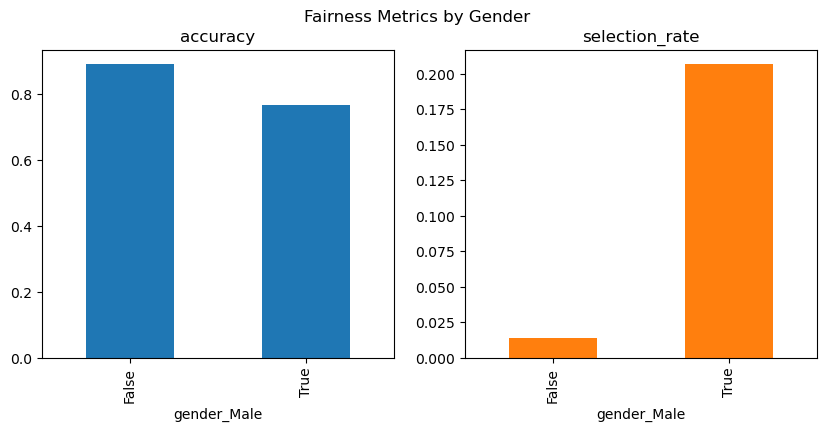

In [17]:
# MetricFrame for fairness analysis
mf = MetricFrame(
    metrics={"accuracy": fair_accuracy, "selection_rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sf_test
)

print("✅ Fairness Metrics")
print(mf.by_group)

# Visualization
mf.by_group.plot(kind="bar", subplots=True, layout=(1, 2), figsize=(10,4), legend=False)
plt.suptitle("Fairness Metrics by Gender")
plt.show()


## 7) Train a Fair Model with Demographic Parity

We will use **Fairlearn’s ExponentiatedGradient** method with a **Demographic Parity** constraint.


In [18]:
constraint = DemographicParity()
fair_model = ExponentiatedGradient(LogisticRegression(max_iter=1000), constraints=constraint)

fair_model.fit(X_train, y_train, sensitive_features=sf_train)
y_pred_fair = fair_model.predict(X_test)

print("✅ Fair Model Trained")
print("Accuracy (Fair Model):", accuracy_score(y_test, y_pred_fair))


✅ Fair Model Trained
Accuracy (Fair Model): 0.7803255195004607


## 8) Fairness Evaluation of the Fair Model


✅ Fair Model Metrics
             accuracy  selection_rate
gender_Male                          
False        0.853545        0.109142
True         0.744392        0.119182


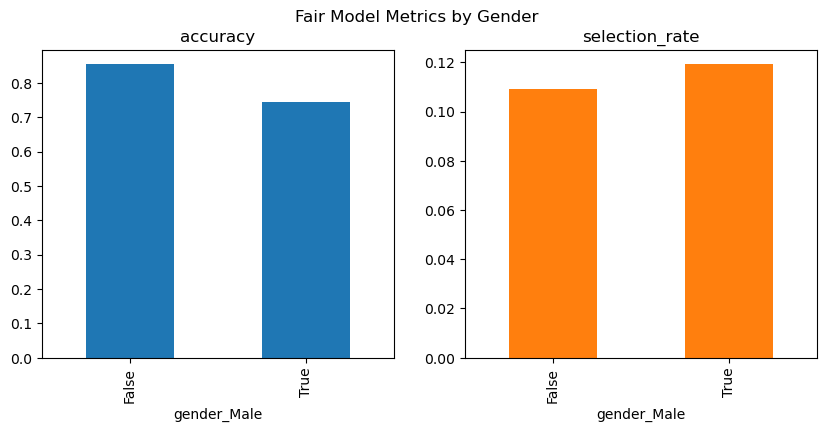

In [19]:
mf_fair = MetricFrame(
    metrics={"accuracy": fair_accuracy, "selection_rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=sf_test
)

print("✅ Fair Model Metrics")
print(mf_fair.by_group)

# Visualization
mf_fair.by_group.plot(kind="bar", subplots=True, layout=(1, 2), figsize=(10,4), legend=False)
plt.suptitle("Fair Model Metrics by Gender")
plt.show()


# ✅ Conclusion

We compared the baseline logistic regression with a fair model under demographic parity.  
- The **baseline model** had higher accuracy but showed differences in selection rates across gender.  
- The **fair model** reduced the disparity, though with a trade-off in accuracy.  

This demonstrates how **algorithmic bias can be detected and mitigated** using Fairlearn.
